<a href="https://colab.research.google.com/github/pjahanvi324/DataScience/blob/main/Claims_Denial_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shape: (5000, 14)
   claim_id  member_id  provider_id  claim_type place_of_service  \
0         1       4174          287    pharmacy       telehealth   
1         2       4507          165  outpatient           clinic   
2         3       1860          293   inpatient         hospital   
3         4       2294          112  outpatient         hospital   
4         5       2130          283          er         hospital   

  primary_dx_group  billed_amount  allowed_amount  paid_amount  \
0         diabetes        1315.08          695.47       645.25   
1      respiratory        1750.04         1526.07      1169.94   
2         diabetes        1100.06          893.17       791.96   
3            ortho        1194.00          944.35       912.70   
4            ortho        2128.02         1771.11      1715.02   

   days_to_submit  has_prior_auth  num_procedures  num_lines  denied  
0              39               1               5          5       0  
1             110            

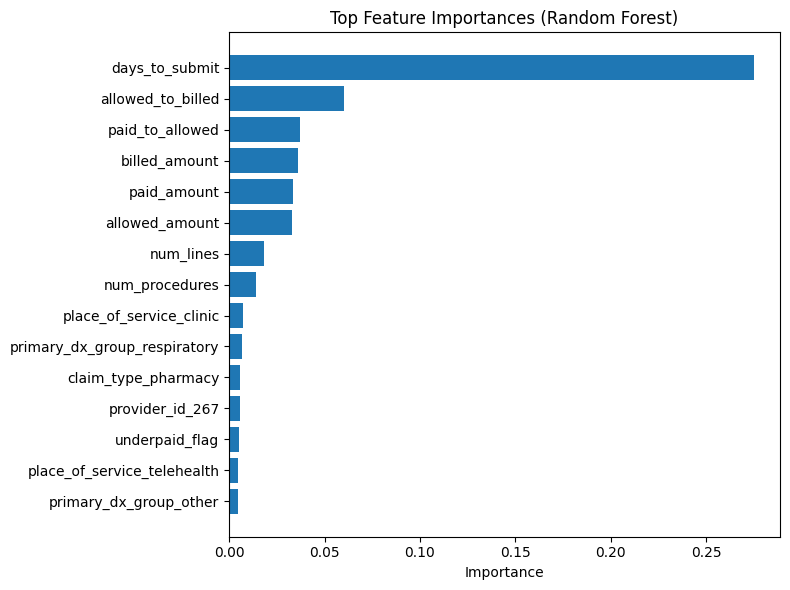

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)


# Generate synthetic claims data

np.random.seed(42)
n_rows = 5000

claim_id = np.arange(1, n_rows + 1)
member_id = np.random.randint(1000, 5000, size=n_rows)
provider_id = np.random.randint(100, 300, size=n_rows)

claim_type = np.random.choice(
    ["inpatient", "outpatient", "pharmacy", "er"],
    size=n_rows,
    p=[0.15, 0.45, 0.25, 0.15]
)

place_of_service = np.random.choice(
    ["hospital", "clinic", "telehealth", "pharmacy"],
    size=n_rows,
    p=[0.4, 0.35, 0.15, 0.10]
)

primary_dx_group = np.random.choice(
    ["cardio", "diabetes", "ortho", "respiratory", "other"],
    size=n_rows,
    p=[0.2, 0.2, 0.2, 0.2, 0.2]
)

billed_amount = np.round(
    np.random.lognormal(mean=7.5, sigma=0.6, size=n_rows), 2
)  # skewed like real claims

# allowed is usually a portion of billed
allowed_ratio = np.random.uniform(0.4, 0.9, size=n_rows)
allowed_amount = np.round(billed_amount * allowed_ratio, 2)

# paid is portion of allowed (some patient responsibility)
paid_ratio = np.random.uniform(0.6, 1.0, size=n_rows)
paid_amount = np.round(allowed_amount * paid_ratio, 2)

days_to_submit = np.random.randint(0, 120, size=n_rows)  # delay between service & claim submission
has_prior_auth = np.random.choice([0, 1], size=n_rows, p=[0.4, 0.6])
num_procedures = np.random.randint(1, 6, size=n_rows)
num_lines = np.random.randint(1, 10, size=n_rows)

# Creating a "risk score" for denial (higher = more likely denied)
risk = (
    0.8 * (billed_amount / (allowed_amount + 1e-3)) +  # high billed/allowed
    0.03 * days_to_submit +
    1.5 * (1 - has_prior_auth) +                      # no prior auth -> higher risk
    0.2 * (claim_type == "er").astype(int) +
    0.15 * (place_of_service == "telehealth").astype(int)
)

# convert risk to probability via sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

prob_denied = sigmoid((risk - risk.mean()) / risk.std())

denied = np.random.binomial(1, prob_denied)

df = pd.DataFrame({
    "claim_id": claim_id,
    "member_id": member_id,
    "provider_id": provider_id,
    "claim_type": claim_type,
    "place_of_service": place_of_service,
    "primary_dx_group": primary_dx_group,
    "billed_amount": billed_amount,
    "allowed_amount": allowed_amount,
    "paid_amount": paid_amount,
    "days_to_submit": days_to_submit,
    "has_prior_auth": has_prior_auth,
    "num_procedures": num_procedures,
    "num_lines": num_lines,
    "denied": denied
})

print("Data shape:", df.shape)
print(df.head())

print("\nDenial rate:", df["denied"].mean())


#  Basic feature engineering

# Financial ratios
df["allowed_to_billed"] = df["allowed_amount"] / (df["billed_amount"] + 1e-3)
df["paid_to_allowed"] = df["paid_amount"] / (df["allowed_amount"] + 1e-3)

# Indicator: underpaid (paid much less than allowed)
df["underpaid_flag"] = (df["paid_to_allowed"] < 0.8).astype(int)


#  Define features & target

target_col = "denied"
y = df[target_col].astype(int)

feature_cols = [
    "member_id",
    "provider_id",
    "claim_type",
    "place_of_service",
    "primary_dx_group",
    "billed_amount",
    "allowed_amount",
    "paid_amount",
    "days_to_submit",
    "has_prior_auth",
    "num_procedures",
    "num_lines",
    "allowed_to_billed",
    "paid_to_allowed",
    "underpaid_flag"
]

X = df[feature_cols].copy()


#  Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


#  Preprocessing: numeric & categorical

numeric_features = [
    "billed_amount",
    "allowed_amount",
    "paid_amount",
    "days_to_submit",
    "num_procedures",
    "num_lines",
    "allowed_to_billed",
    "paid_to_allowed",
    "underpaid_flag"
]


categorical_features = [
    "claim_type",
    "place_of_service",
    "primary_dx_group",
    "member_id",
    "provider_id"
]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# Model 1 — Logistic Regression

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=42
    ))
])

log_reg_clf.fit(X_train, y_train)

y_pred_lr = log_reg_clf.predict(X_test)
y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Performance ===")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_lr))


#  Model 2 — Random Forest

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Performance ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=4))

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


#  Feature importance (approx, from RF)

rf_model = rf_clf.named_steps["model"]
ohe = rf_clf.named_steps["preprocess"].named_transformers_["cat"]

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 15 Features by Importance (Random Forest):")
print(feat_imp.head(15))

plt.figure(figsize=(8, 6))
top_n = 15
plt.barh(feat_imp["feature"].head(top_n)[::-1],
         feat_imp["importance"].head(top_n)[::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
